### Dynamic College and Labor Supply Model

This model describes an individual’s lifetime decision between **education** and **working**, accounting for **consumption**, **savings** and **human capital accumulation**.

At the initial period \( t = 0 \), the agent chooses whether to attend college or enter the labor market, comparing the expected values of each path. If college is chosen, the agent consumes while incurring education costs and increasing human capital. Upon graduation, the agent enters the labor market, deciding how much to **consume** and **work**, with wages depending on accumulated human capital.

- If **college** is chosen, the agent remains a student for $ t_{\text{college}} = 4 $ years, during which they **consume**, **pay tuition**, and **accumulate human capital**. The psychic cost $ \kappa_X $ is also incurred each year.
- After graduation, at time $t + t_{\text{college}}$, the agent enters the **labor market** with enhanced human capital and starts making labor supply decisions.

- If **work** is chosen directly, the agent starts earning immediately and decides each period how much to **consume** and **work**, while human capital grows on-the-job.

---


#### Initial Decision ($t = 0$)


$$
V_0(X, I) = \max \left\{ \mathbb{E} \left[ V^E\right], \mathbb{E} \left[ V^W \right] \right\}
$$

#### College ($s_t = E$)




$$
V^E _t(E, A_t, k_t, z_t, \epsilon_t) = \max_{c_t} \left\{ \frac{c_t^{1-\rho}}{1-\rho} - \kappa_X + \beta \mathbb{E} \left[ V^W _{t+1}(s_{t+1}, e, A_{t+1}, k_{t+1}\, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r) . A_t - c_t - \it{college cost}
$$

$$
k_{t+1} = k_t + h_t^E
$$



#### Labor Market ($s_t = W$)



$$
V^W _t(W, e, A_t, k_t, 0) = \max_{c_t, h_t} \left\{ \frac{c_t^{1-\rho}}{1-\rho} -\varphi \frac{h_t^{1+\eta}}{1+\eta} + \beta \mathbb{E} \left[ V^W _{t+1}(W, e, A_{t+1}, k_{t+1}, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r). A_t + (1 - \tau_{\text{tax}}) w_t h_t - c_t
$$

$$
w_t = w_0(1 + \alpha k_t)
$$

$$
k_{t+1} = k_t + h_t
$$

---

### Model Parameter Settings

| **Parameter**         | **Value**                                         | **Description**                                                     |
|----------------------|---------------------------------------------------|---------------------------------------------------------------------|
| `T`                  | 50                                                | Number of periods (e.g., age 18 to 68)                              |
| `t_college`          | 4                                                 | Duration of college before entering the labor market                |
| `β` (`beta`)         | 0.96                                              | Discount factor (annual)                                            |
| `ρ` (`rho`)          | 1.2                                              | Relative risk aversion (CRRA utility)                               |
| `η` (`eta`)          | 0.5                                               | Inverse Frisch elasticity (elasticity ≈ 2)                          |
| `ϕ` (`phi`)          | 1.0                                               | Weight on disutility of labor                                       |
| `r`                  | 0.03                                              | Real interest rate (annual)                                         |
| `w_0`                | 30,000                                            | Base wage (e.g., starting wage at age 18)                           |
| `α` (`alpha`)        | 0.1                                               | Wage increase per year of human capital (education or experience)   |
| `τ_tax`              | 0.25                                              | Labor income tax rate                                               |
| `κ_X` (`kappa_X`)    | 3,000                                             | Annual psychic cost of attending college                            |
| `college cost`       | 12,000                                            | Annual direct college cost                                          |
| `college boost`      | 4.0                                               | Human capital gain per year of education (1 unit per year)          |
| `a_max`              | 1,000,000                                         | Maximum asset level in grid                                         |
| `Na`                 | 100                                               | Number of grid points for assets                                    |
| `Nk`                 | 50                                                | Number of grid points for human capital                             |
| `k_grid`             | `nonlinspace(0.0, 30.0, Nk, 1.1)`                 | Human capital grid: up to 30 years of experience/schooling          |
| `a_grid`             | `nonlinspace(0.0, a_max, Na, 2.0)`               | Asset grid with finer resolution near zero                          |
| `sim_a_init`         | `rand(rng, simN) .* 100_000`                      | Initial asset distribution: uniformly random up to 100,000          |
| `sim_k_init`         | `zeros(Float64, simN)`                            | Initial human capital: all individuals start with zero              |




### Setup

In [2]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads, DataFrames
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile
using DataFrames

### Model

In [ ]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

# =============================================================================
# Dynamic Labor Model Definition with College Decision
#
# This mutable struct defines the model parameters, state grids, solution arrays,
# and simulation arrays for a dynamic consumption-saving model with a college decision.
#
# Key components:
# - Model parameters (e.g., T, beta, r, w, etc.)
# - State variable grids (for assets 'a_grid' and human capital 'k_grid')
# - Solution arrays for both work and college choices (consumption, labor, and value functions)
# - Simulation arrays for consumption, assets, labor, and capital over simulated life paths
# - Other auxiliary arrays, such as initial conditions, random draws, and wage vector (w_vec)
# - Parameters for the college decision (college_cost and college_boost)
# =============================================================================
mutable struct ConSavLaborCollege
    T::Int                     # Total number of periods
    t_college::Int             # Number of college periods
    rho::Float64               # Risk aversion parameter (or relative risk aversion)
    beta::Float64              # Discount factor
    phi::Float64               # Parameter (e.g., disutility of labor or related to college)
    eta::Float64               # Another parameter (e.g., related to preferences)
    alpha::Float64             # Wage increase per year of human capital
    w::Float64                 # Base wage level
    tau::Float64               # Tax rate or other scaling parameter on wage income
    r::Float64                 # Interest rate on assets
    a_max::Float64             # Maximum asset level in the grid
    a_min::Float64             # Minimum asset level (borrowing constraint)
    Na::Int                    # Number of grid points for assets
    k_max::Float64             # Maximum human capital level in the grid
    Nk::Int                    # Number of grid points for human capital
    simT::Int                  # Number of simulation periods (typically equals T)
    simN::Int                  # Number of simulation agents
    a_grid::Vector{Float64}    # Grid for assets (state variable)
    k_grid::Vector{Float64}    # Grid for human capital (state variable)

    # Solution arrays for the working alternative
    sol_c_work::Array{Float64, 3}  # Optimal consumption when working
    sol_h_work::Array{Float64, 3}  # Optimal labor supply when working
    sol_v_work::Array{Float64, 3}  # Value function when working

    # Solution arrays for the college alternative
    sol_c_college::Array{Float64, 3}  # Optimal consumption when in college
    sol_h_college::Array{Float64, 3}  # Optimal labor supply when in college (typically zero)
    sol_v_college::Array{Float64, 3}  # Value function when in college

    # Simulation arrays (each row corresponds to one simulated agent over time)
    sim_c::Matrix{Float64}      # Consumption over time
    sim_h::Matrix{Float64}      # Labor supply over time
    sim_a::Matrix{Float64}      # Asset holdings over time
    sim_k::Matrix{Float64}      # Human capital over time
    sim_a_init::Vector{Float64} # Initial asset levels for simulated agents
    sim_k_init::Vector{Float64} # Initial human capital for simulated agents
    
    draws_uniform::Matrix{Float64}  # Matrix of uniform random draws for simulation purposes
    w_vec::Vector{Float64}          # Wage vector over time (can vary across periods)
    college_cost::Float64           # Cost of attending college per period (or overall cost structure)
    college_boost::Float64          # Increase in human capital (or productivity boost) from college
end

# =============================================================================
# Constructor for ConSavLaborCollege
#
# This constructor initializes the model with default parameters or user-specified ones.
# It sets up:
# - The time horizon (T) and the number of college periods (t_college)
# - The asset and human capital grids using the nonlinspace utility function
# - Empty solution arrays (filled with NaN) for both work and college alternatives
# - Simulation arrays with appropriate dimensions, including initial conditions
# - The wage vector (w_vec) and random draws for simulation purposes
# - The parameters specific to the college decision (college_cost and college_boost)
# =============================================================================
function ConSavLaborCollege(; 
    T::Int=50, t_college::Int=4, beta::Float64=0.96, rho::Float64=1.2, 
    r::Float64=0.02, a_max::Float64=1000000.0, Na::Int=100, 
    simN::Int=5000, a_min::Float64=0.0, k_max::Float64=50.0, Nk::Int=50, 
    w::Float64=30000.0, tau::Float64=0.25, eta::Float64=0.5, alpha::Float64=0.1, 
    phi::Float64=1.0, seed::Int=1234, college_cost::Float64=12000.0, 
    college_boost::Float64=4.0)
    
    simT = T  # Simulation time equals model time horizon
    
    # --- Grids for state variables ---
    a_grid = nonlinspace(a_min, a_max, Na, 2.0);    # Nonlinear grid for assets
    k_grid = nonlinspace(0.0, k_max, Nk, 1.1);       # Nonlinear grid for human capital

    # --- Initialize solution arrays (3D arrays for each period, asset, and human capital grid point) ---
    sol_c_work = fill(NaN, (T, Na, Nk));
    sol_h_work = fill(NaN, (T, Na, Nk));
    sol_v_work = fill(NaN, (T, Na, Nk));

    sol_c_college = fill(NaN, (T, Na, Nk));
    sol_h_college = fill(NaN, (T, Na, Nk));
    sol_v_college = fill(NaN, (T, Na, Nk));

    # --- Initialize simulation arrays (rows: simulated agents, columns: periods) ---
    sim_c = fill(NaN, (simN, T));
    sim_h = fill(NaN, (simN, T));
    sim_a = fill(NaN, (simN, T));
    sim_k = fill(NaN, (simN, T));

    # --- Set initial conditions for simulation ---
    rng = MersenneTwister(seed);
    sim_a_init = rand(rng, simN) .* 100000;  # Initial assets drawn from a uniform distribution
    sim_k_init = zeros(Float64, simN);         # Initial human capital is set to zero

    # --- Initialize wage vector and random draws for simulation ---
    w_vec = fill(w, T);                        # Wage remains constant over time by default
    draws_uniform = rand(rng, simN, T);          # Uniform random draws for simulation purposes
    
    # --- Return an instance of ConSavLaborCollege with all fields initialized ---
    return ConSavLaborCollege(
        T, t_college, rho, beta, phi, eta, alpha, w, tau, r,
        a_max, a_min, Na, k_max, Nk, simT, simN, a_grid, k_grid,
        sol_c_work, sol_h_work, sol_v_work, sol_c_college, sol_h_college, sol_v_college,
         sim_c, sim_h, sim_a, sim_k,
        sim_a_init, sim_k_init, draws_uniform, w_vec, college_cost, college_boost
    )
end

ConSavLaborCollege

In [ ]:
# --------------------------
# Model Solver for College Periods
# --------------------------
function solve_model_college!(model::ConSavLaborCollege)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c_college, model.sol_h_college, model.sol_v_college

    # --- Final period (t = T) ---
    # For each asset and capital grid point, choose optimal hours that maximize utility.
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            # Objective: minimize the negative utility at terminal period.
            function obj_last(h_vec::Vector, grad::Vector)
                return obj_last_period(model, h_vec[1], assets, capital, T)
            end
            # Use LN_COBYLA (derivative-free) to optimize over hours (constrained between 0 and 1)
            opt = Opt(:LN_COBYLA, 1)
            lower_bounds!(opt, [0.0])
            upper_bounds!(opt, [1.0])
            xtol_rel!(opt, 1e-4)
            min_objective!(opt, obj_last)
            init = [0.5]  # Initial guess for hours
            (minf, h_vec, ret) = optimize(opt, init)
            h_opt = h_vec[1]
            cons = assets + wage_func(model, capital, T) * h_opt
            sol_h[T, i_a, i_k] = h_opt
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = -minf  # Utility is negative of the minimized objective
        end
    end

    # --- Work Periods (t = T-1 to t_college + 1) ---
    # Solve for consumption and hours when agents are working.
    @showprogress 1 "Solving college periods..." for t in (T-1):-1:(model.t_college + 1)
        interp = create_interp(model, sol_v, t+1)  # Interpolate the value function at next period
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                # Objective: maximize utility from working by optimizing consumption and labor.
                function obj_work(x_vec::Vector, grad::Vector)
                    return -value_of_work_choice(model, x_vec[1], x_vec[2], assets, capital, t, interp)
                end
                # Optimize over two variables: consumption and hours (h in [0,1])
                opt = Opt(:LN_COBYLA, 2)
                lower_bounds!(opt, [1e-6, 0.0])
                upper_bounds!(opt, [Inf, 1.0])
                xtol_rel!(opt, 1e-4)
                min_objective!(opt, obj_work)
                init = [max(sol_c[t+1, i_a, i_k], 1e-6), clamp(sol_h[t+1, i_a, i_k], 0.0, 1.0)]
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]
                sol_h[t, i_a, i_k] = x_opt[2]
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end

    # --- College Periods (t = t_college to 1) ---
    # In college, no labor is supplied; only consumption is optimized.
    for t in model.t_college:-1:1
        interp = create_interp(model, sol_v, t+1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_college(c_vec::Vector, grad::Vector)
                    return -value_of_college_choice(model, c_vec[1], assets, capital, t, interp)
                end
                opt = Opt(:LN_COBYLA, 1)
                lower_bounds!(opt, [1e-6])
                upper_bounds!(opt, [Inf])
                xtol_rel!(opt, 1e-6)
                min_objective!(opt, obj_college)
                init = [max(sol_c[t+1, i_a, i_k], 1e-6)]
                (minf, c_vec_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = c_vec_opt[1]
                sol_h[t, i_a, i_k] = 0.0  # No work during college
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end 

    return model
end

# --------------------------
# Model Solver for Work Periods
# --------------------------
function solve_model_work!(model::ConSavLaborCollege)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c_work, model.sol_h_work, model.sol_v_work

    # --- Final period (t = T) ---
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            function obj_last(h_vec::Vector, grad::Vector)
                return obj_last_period(model, h_vec[1], assets, capital, T)
            end
            opt = Opt(:LN_COBYLA, 1)
            lower_bounds!(opt, [0.0])
            upper_bounds!(opt, [1.0])
            xtol_rel!(opt, 1e-4)
            min_objective!(opt, obj_last)
            init = [0.5]
            (minf, h_vec, ret) = optimize(opt, init)
            h_opt = h_vec[1]
            cons = assets + wage_func(model, capital, T) * h_opt
            sol_h[T, i_a, i_k] = h_opt
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = -minf
        end
    end

    # --- Earlier periods (t = T-1 to 1) ---
    @showprogress 1 "Solving working model..." for t in (T-1):-1:1
        interp = create_interp(model, sol_v, t + 1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_work(x_vec::Vector, grad::Vector)
                    return -value_of_work_choice(model, x_vec[1], x_vec[2], assets, capital, t, interp)
                end
                opt = Opt(:LN_COBYLA, 2)  # Optimize over consumption and labor
                lower_bounds!(opt, [1e-6, 0.0])
                upper_bounds!(opt, [Inf, 1.0])
                xtol_rel!(opt, 1e-4)
                min_objective!(opt, obj_work)
                init = [max(sol_c[t + 1, i_a, i_k], 1e-6), clamp(sol_h[t + 1, i_a, i_k], 0.0, 1.0)]
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]  # Optimal consumption
                sol_h[t, i_a, i_k] = x_opt[2]  # Optimal labor
                sol_v[t, i_a, i_k] = -minf     # Value function
            end
        end
    end

    return model
end

# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------
@inline function util_work(model::ConSavLaborCollege, c::Float64, h::Float64)
    return (c^(1.0 - model.rho)) / (1.0 - model.rho) - model.phi * (h^(1.0 + model.eta)) / (1.0 + model.eta)
end

# Utility function for college periods with No labor disutility
@inline function util_college(model::ConSavLaborCollege, c::Float64)
    return (c^(1.0 - model.rho)) / (1.0 - model.rho) # - pychic cost
end

# Wage function
@inline function wage_func(model::ConSavLaborCollege, k::Float64, t::Int)
    return (1.0 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * k)
end

# Objective function for the last period
function obj_last_period(model::ConSavLaborCollege, h::Float64, assets::Float64, capital::Float64, t::Int)
    income = wage_func(model, capital, t) * h
    cons = assets + income  # Consume all resources
    u = util_work(model, cons, h)
    return -u  # Minimize negative utility
end

# Value of college choice
function value_of_college_choice(model::ConSavLaborCollege, c::Float64, assets::Float64,
    capital::Float64, t::Int, interp)
    # Current penalty for negative consumption
    penalty_c = c < 0.0 ? abs(c) * 1.0e6 : 0.0
    # Compute next period's assets
    a_next = (1.0 + model.r) * assets - c - model.college_cost
    # Penalty for assets below a_min
    penalty_a = a_next < model.a_min ? (model.a_min - a_next) * 1.0e6 : 0.0
    # Utility and continuation value
    util_now = util_college(model, c)
    k_next = capital + model.college_boost
    V_next = interp(a_next, k_next)
    return util_now + model.beta * V_next - penalty_c - penalty_a
end

# Value of work choice
function value_of_work_choice(model::ConSavLaborCollege, c::Float64, h::Float64, assets::Float64,
    capital::Float64, t::Int, interp)
    # Current penalties for negative consumption and hours
    penalty_c = c < 0.0 ? abs(c) * 1.0e5 : 0.0
    penalty_h = h < 0.0 ? abs(h) * 1.0e5 : 0.0
    # Compute next period's assets
    income = wage_func(model, capital, t) * h
    a_next = (1.0 + model.r) * assets + income - c
    # Penalty for assets below a_min
    penalty_a = a_next < model.a_min ? (model.a_min - a_next) * 1.0e5 : 0.0
    # Utility and continuation value
    util_now = util_work(model, c, h)
    k_next = capital + h
    V_next = interp(a_next, k_next)
    return util_now + model.beta * V_next - penalty_c - penalty_h - penalty_a
end
# Interpolation helper function
function create_interp(model::ConSavLaborCollege, sol_v::Array{Float64, 3}, t::Int)
    return LinearInterpolation((model.a_grid, model.k_grid), sol_v[t, :, :], extrapolation_bc=Line())
end

# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions

function simulate_model!(model::ConSavLaborCollege)
    # ------------------------------------------------
    # 1) Basic setup and parameter extraction
    # ------------------------------------------------
    simN, T         = model.simN, model.T
    a_max, k_max    = model.a_max, model.k_max
    t_college       = model.t_college
    r               = model.r
    college_cost    = model.college_cost
    college_boost   = model.college_boost
    a_min           = model.a_min
    sim_c, sim_h    = model.sim_c, model.sim_h
    sim_a, sim_k    = model.sim_a, model.sim_k
    sim_a_init      = model.sim_a_init
    sim_k_init      = model.sim_k_init

    # ------------------------------------------------
    # 2) Initial conditions
    # ------------------------------------------------
    # If your model sets sim_a_init/sim_k_init externally, they go here:
    a0_vec = sim_a_init
    k0_vec = sim_k_init

    # ------------------------------------------------
    # 3) Compute initial values & choose college vs. work
    # ------------------------------------------------
    #  - We interpolate at t=1 to see which choice yields higher value
    interp_v_college = LinearInterpolation((model.a_grid, model.k_grid),
                                           model.sol_v_college[1, :, :],
                                           extrapolation_bc=Line())
    interp_v_work = LinearInterpolation((model.a_grid, model.k_grid),
                                        model.sol_v_work[1, :, :],
                                        extrapolation_bc=Line())

    # For each agent, store whether they choose college or work
    path_choice = Vector{Symbol}(undef, simN)

    for i in 1:simN
        V_college = interp_v_college(a0_vec[i], k0_vec[i])
        V_work    = interp_v_work(a0_vec[i], k0_vec[i])
        path_choice[i] = V_college > V_work ? :college : :work
    end

    # ------------------------------------------------
    # 4) Precompute policy-function interpolators
    # ------------------------------------------------
    # We have T policy functions for each choice
    interp_c_college = [
        LinearInterpolation((model.a_grid, model.k_grid),
                            model.sol_c_college[t, :, :],
                            extrapolation_bc=Line()) for t in 1:T
    ]
    interp_h_college = [
        LinearInterpolation((model.a_grid, model.k_grid),
                            model.sol_h_college[t, :, :],
                            extrapolation_bc=Line()) for t in 1:T
    ]
    interp_c_work = [
        LinearInterpolation((model.a_grid, model.k_grid),
                            model.sol_c_work[t, :, :],
                            extrapolation_bc=Line()) for t in 1:T
    ]
    interp_h_work = [
        LinearInterpolation((model.a_grid, model.k_grid),
                            model.sol_h_work[t, :, :],
                            extrapolation_bc=Line()) for t in 1:T
    ]

    # ------------------------------------------------
    # 5) Initialize the simulation arrays
    # ------------------------------------------------
    sim_a[:, 1] = a0_vec
    sim_k[:, 1] = k0_vec

    # ------------------------------------------------
    # 6) Simulate forward for each t = 1,...,T
    # ------------------------------------------------
    for t in 1:T
        for i in 1:simN

            # Retrieve current states
            a = sim_a[i, t]
            k = sim_k[i, t]

            # Choose consumption & hours via policy
            if path_choice[i] == :college
                c = interp_c_college[t](a, k)
                h = interp_h_college[t](a, k)
            else
                c = interp_c_work[t](a, k)
                h = interp_h_work[t](a, k)
            end

            sim_c[i, t] = c
            sim_h[i, t] = h

            # If not in the final period, update next period's states
            if t < T
                if path_choice[i] == :college
                    # Are we in the "college cost" phase?
                    if t <= t_college
                        # Pay college cost in each college period
                        a_next = (1 + r)*a - c - college_cost
                        k_next = k + college_boost
                    else
                        # Post-college: earn wage * hours
                        income = wage_func(model, k, t) * h
                        a_next = (1 + r)*a + income - c
                        k_next = k + h
                    end
                else
                    # Working path
                    income = wage_func(model, k, t) * h
                    a_next = (1 + r)*a + income - c
                    k_next = k + h
                end

                # Enforce borrowing constraint
                a_next = max(a_next, a_min)

                sim_a[i, t+1] = a_next
                sim_k[i, t+1] = k_next

                # -- Debugging for a single agent (i=1) in first few periods
                #if i == 1 && t <= 50
                    #println("\nDebug i=1, t=$t, path=$(path_choice[i])")
                    #println("  a     = $(round(a, digits=2))")
                    #println("  k     = $(round(k, digits=2))")
                    #println("  c     = $(round(c, digits=2))")
                    #println("  h     = $(round(h, digits=2))")
                    #if path_choice[i] == :college && t <= t_college
                        #println("  (College cost paid!)")
                    #else
                        #println("  wage_func(k=$k, t=$t) = $(round(wage_func(model, k, t), digits=2))")
                    #end
                    #println("  => a_next = $(round(a_next, digits=2))")
                    #println("  => k_next = $(round(k_next, digits=2))")
                #end
            end
        end
    end

    # ------------------------------------------------
    # 7) Store final results, print aggregates
    # ------------------------------------------------
    model.sim_a = sim_a
    model.sim_c = sim_c
    model.sim_h = sim_h
    model.sim_k = sim_k

    num_college = sum(path_choice .== :college)
    num_work    = sum(path_choice .== :work)

    println("Number choosing college: $num_college")
    println("Number choosing work:    $num_work")
    
    # Show average initial assets by choice
    #college_inits = mean(a0_vec[path_choice .== :college])
    #work_inits    = mean(a0_vec[path_choice .== :work])
    #println("Initial assets (college group): $(round(college_inits, digits = 2))")
    #println("Initial assets (work group):    $(round(work_inits, digits = 2))")
    #println("---------------------------------------\n")

    return model, path_choice
end

simulate_model! (generic function with 1 method)

### Model Structure and Policy Function Visualization

- **Asset Grid (Top-left):**  
  Displays the nonlinear asset grid, with denser points at low asset levels.

- **Terminal Value Function (Top-right):**  
Depicts the value function at \(T = 50\), representing lifetime utility as a function of assets.

- **Terminal Consumption Policy (Middle-left):**  
  Shows optimal consumption at the terminal period (\(T = 50\)), where agents consume all available resources.

- **Early Consumption Policy (Middle-right):**  
  Illustrates optimal consumption at an earlier period (\(T = 10\)), reflecting saving behavior.

- **Early Labor Policy (Bottom-left):**  
  Displays optimal labor supply at \(T = 10\).

- **Terminal Labor Policy (Bottom-right):**  
  Shows optimal labor supply at \(T = 50\).

This layout clarifies how the asset grid design and time dynamics shape optimal consumption and labor decisions.

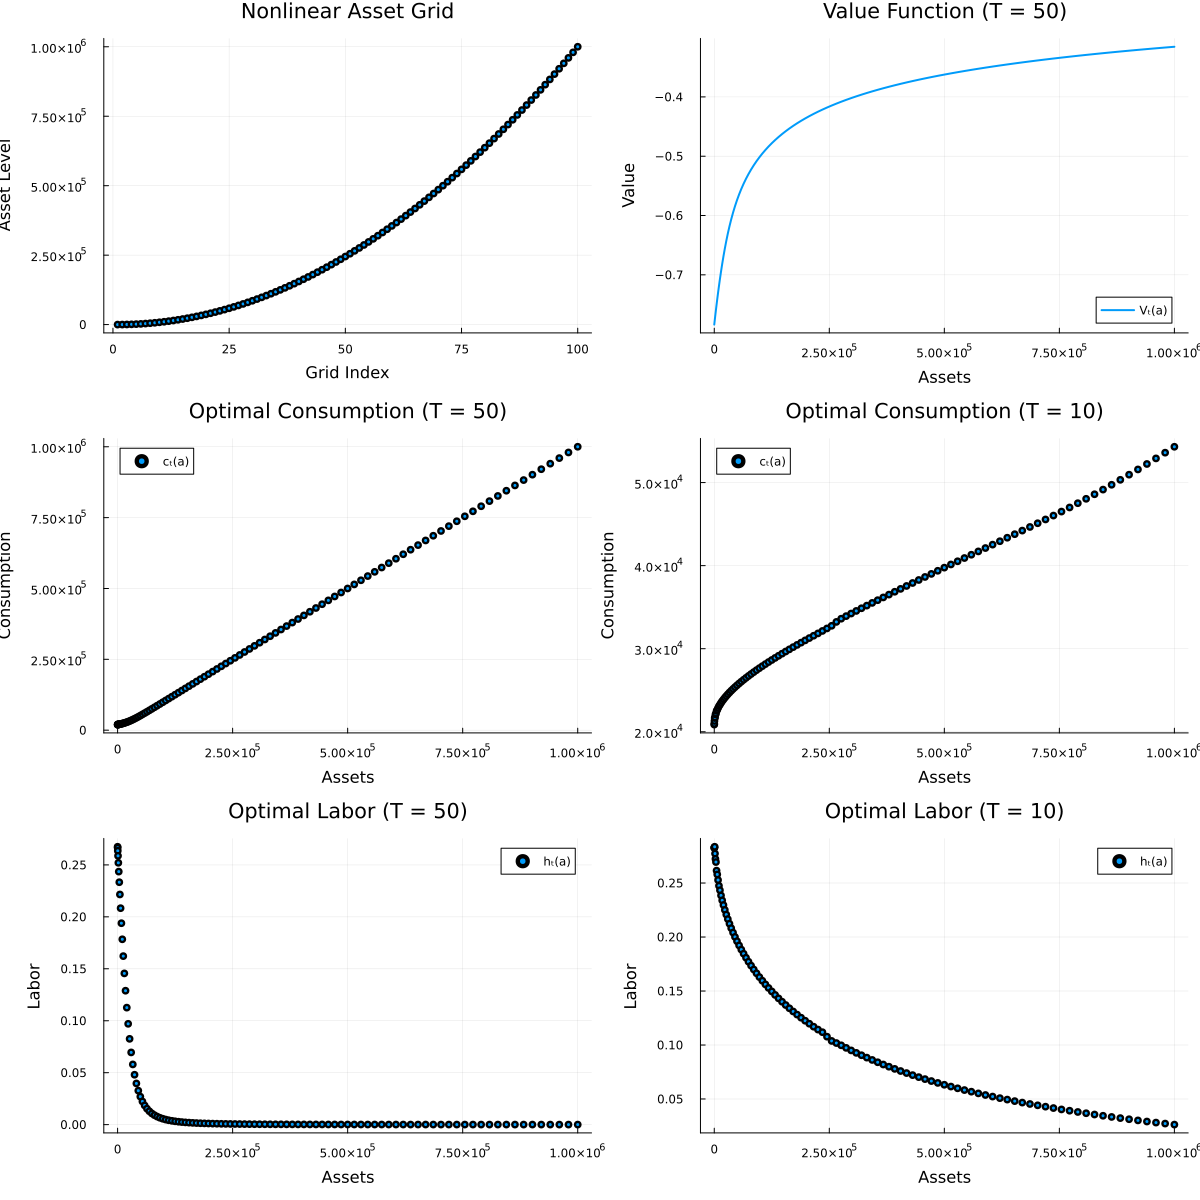

In [58]:

# Choose a representative labor grid index (e.g. the median)
k_mid = Int(ceil(length(model_baseline.k_grid)/2))
T_terminal = model_baseline.T  # Terminal period (e.g., 50)
t_early = 10          # An earlier period for comparison

# 1. Plot the nonlinear asset grid
p1 = scatter(1:length(model_baseline.a_grid), model_baseline.a_grid,
    xlabel = "Grid Index",
    ylabel = "Asset Level",
    title = "Nonlinear Asset Grid",
    legend = false,
    markersize = 3)

# 2. Plot optimal consumption policy at terminal period (T = model.T)
# Here we fix the labor dimension at k_mid.
p2 = scatter(model_baseline.a_grid, model_baseline.sol_c_college[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(T_terminal))",
    label = "cₜ(a)",
    markersize = 3)

# 3. Plot value function at terminal period (T = model.T)
# Note: use 'sol_v' (not sol_V) as per your definition.
p3 = plot(model_baseline.a_grid, model_baseline.sol_v_college[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2)

# 4. Plot optimal consumption policy at an earlier period (e.g., T = 10)
p4 = scatter(model_baseline.a_grid, model_baseline.sol_c_college[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(t_early))",
    label = "cₜ(a)",
    markersize = 3)

p5 = scatter(model_baseline.a_grid, model_baseline.sol_h_college[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Labor",
    title = "Optimal Labor (T = $(t_early))",
    label = "hₜ(a)",
    markersize = 3)

p6 = scatter(model_baseline.a_grid, model_baseline.sol_h_college[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Labor",
    title = "Optimal Labor (T = $(T_terminal))",
    label = "hₜ(a)",
    markersize = 3)

# Combine all plots into a 2×2 grid layout for comparison
plot(p1, p3, p2, p4, p6, p5, layout = (3, 2), size = (1200, 1200))

### Model and Counterfactual Simulation in a T-Period 
This script solves and simulates a finite-horizon (T-period) consumption-saving model under different economic scenarios. It compares a baseline model with 8 counterfactual experiments, focusing on how each setting affects average consumption and asset accumulation over time.

In [14]:
# --------------------------
# Baseline Model
# --------------------------
# This section sets up and solves the baseline model using the default parameters 
# defined in ConSavLaborCollege. The baseline serves as the reference point for the counterfactual analyses.
println("\n---------------------------------------")
println("Baseline Model")
model_baseline = ConSavLaborCollege();
solve_model_college!(model_baseline);
solve_model_work!(model_baseline);
simulate_model!(model_baseline);

# --------------------------
# Counterfactual 1: Higher College Cost
# --------------------------
# In this scenario, the college cost is raised from the baseline (e.g., 12000.0) to 15000.0.
# Higher tuition may discourage college attendance due to increased financial barriers.
println("\n---------------------------------------")
println("Counterfactual 1: Higher College Cost (college_cost = 15000.0)")
model_cf1 = ConSavLaborCollege(college_cost=15000.0);
solve_model_college!(model_cf1);
solve_model_work!(model_cf1);
simulate_model!(model_cf1);

# --------------------------
# Counterfactual 2: Lower College Cost
# --------------------------
# Here, the college cost is decreased from the baseline to 9000.0.
# Lower tuition makes college more affordable, potentially increasing college attendance.
println("\n---------------------------------------")
println("Counterfactual 2: Lower College Cost (college_cost = 9000.0)")
model_cf2 = ConSavLaborCollege(college_cost=9000.0);
solve_model_college!(model_cf2);
solve_model_work!(model_cf2);
simulate_model!(model_cf2);

# --------------------------
# Counterfactual 3: Higher College Boost
# --------------------------
# In this scenario, the benefit (boost) from attending college is increased from 4.0 to 5.0.
# A higher college boost implies greater productivity or wage gains after college, making college more attractive.
println("\n---------------------------------------")
println("Counterfactual 3: Higher College Boost (college_boost = 5.0)")
model_cf3 = ConSavLaborCollege(college_boost=5.0);
solve_model_college!(model_cf3);
solve_model_work!(model_cf3);
simulate_model!(model_cf3);

# --------------------------
# Counterfactual 4: Lower College Boost
# --------------------------
# Here, the boost is decreased (set to 2.0), reducing the productivity/wage gain from college.
# This may make college less attractive relative to work.
println("\n---------------------------------------")
println("Counterfactual 4: Lower College Boost (college_boost = 2.0)")
model_cf4 = ConSavLaborCollege(college_boost=2.0);
solve_model_college!(model_cf4);
solve_model_work!(model_cf4);
simulate_model!(model_cf4);

# --------------------------
# Counterfactual 5: Higher Interest Rate
# --------------------------
# The interest rate is increased (e.g., to 0.04), which can affect the return on savings
# and the cost of borrowing, potentially altering college and work decisions.
println("\n---------------------------------------")
println("Counterfactual 5: Higher Interest Rate (r = 0.04)")
model_cf5 = ConSavLaborCollege(r=0.04);
solve_model_college!(model_cf5);
solve_model_work!(model_cf5);
simulate_model!(model_cf5);

# --------------------------
# Counterfactual 6: Lower Interest Rate
# --------------------------
# In this case, the interest rate is lowered to 0.01, reducing borrowing costs and possibly
# making college more appealing if financing is easier.
println("\n---------------------------------------")
println("Counterfactual 6: Lower Interest Rate (r = 0.01)")
model_cf6 = ConSavLaborCollege(r=0.01);
solve_model_college!(model_cf6);
solve_model_work!(model_cf6);
simulate_model!(model_cf6);

# --------------------------
# Counterfactual 7: Lower Wage Increase per Year of Human Capital
# --------------------------
# In this scenario, alpha (the wage increase per year of human capital) is lowered (e.g., to 0.05).
# A lower wage increase per year of human capital implies that additional human capital yields a smaller
# increase in wages, which might discourage investing in college.
println("\n---------------------------------------")
println("Counterfactual 7: Lower Wage Increase per Year of Human Capital (alpha = 0.05)")
model_cf7 = ConSavLaborCollege(alpha=0.05);
solve_model_college!(model_cf7);
solve_model_work!(model_cf7);
simulate_model!(model_cf7);

# --------------------------
# Counterfactual 8: Higher Wage Increase per Year of Human Capital
# --------------------------
# Here, alpha is raised (e.g., to 0.3). A higher wage increase per year of human capital means that 
# each additional year of human capital leads to a larger increase in wages, potentially making college more attractive.
println("\n---------------------------------------")
println("Counterfactual 8: Higher Wage Increase per Year of Human Capital (alpha = 0.3)")
model_cf8 = ConSavLaborCollege(alpha=0.3);
solve_model_college!(model_cf8);
solve_model_work!(model_cf8);
simulate_model!(model_cf8);


---------------------------------------
Baseline Model


Solving college periods... 100%|█████████████████████████| Time: 0:00:21
Solving working model... 100%|███████████████████████████| Time: 0:00:22


Number choosing college: 2299
Number choosing work:    2701

---------------------------------------
Counterfactual 1: Higher College Cost (college_cost = 15000.0)


Solving college periods... 100%|█████████████████████████| Time: 0:00:21
Solving working model... 100%|███████████████████████████| Time: 0:00:22


Number choosing college: 1840
Number choosing work:    3160

---------------------------------------
Counterfactual 2: Lower College Cost (college_cost = 9000.0)


Solving college periods... 100%|█████████████████████████| Time: 0:00:21
Solving working model... 100%|███████████████████████████| Time: 0:00:21


Number choosing college: 2968
Number choosing work:    2032

---------------------------------------
Counterfactual 3: Higher College Boost (college_boost = 5.0)


Solving college periods... 100%|█████████████████████████| Time: 0:00:22
Solving working model... 100%|███████████████████████████| Time: 0:00:22


Number choosing college: 2299
Number choosing work:    2701

---------------------------------------
Counterfactual 4: Lower College Boost (college_boost = 2.0)


Solving college periods... 100%|█████████████████████████| Time: 0:00:21
Solving working model... 100%|███████████████████████████| Time: 0:00:22


Number choosing college: 2103
Number choosing work:    2897

---------------------------------------
Counterfactual 5: Higher Interest Rate (r = 0.04)


Solving college periods... 100%|█████████████████████████| Time: 0:00:20
Solving working model... 100%|███████████████████████████| Time: 0:00:21


Number choosing college: 2510
Number choosing work:    2490

---------------------------------------
Counterfactual 6: Lower Interest Rate (r = 0.01)


Solving college periods... 100%|█████████████████████████| Time: 0:00:22
Solving working model... 100%|███████████████████████████| Time: 0:00:23


Number choosing college: 2299
Number choosing work:    2701

---------------------------------------
Counterfactual 7: Lower Wage Increase per Year of Human Capital (alpha = 0.05)


Solving college periods... 100%|█████████████████████████| Time: 0:00:21
Solving working model... 100%|███████████████████████████| Time: 0:00:22


Number choosing college: 2230
Number choosing work:    2770

---------------------------------------
Counterfactual 8: Higher Wage Increase per Year of Human Capital (alpha = 0.3)


Solving college periods... 100%|█████████████████████████| Time: 0:00:18
Solving working model... 100%|███████████████████████████| Time: 0:00:18


Number choosing college: 2299
Number choosing work:    2701


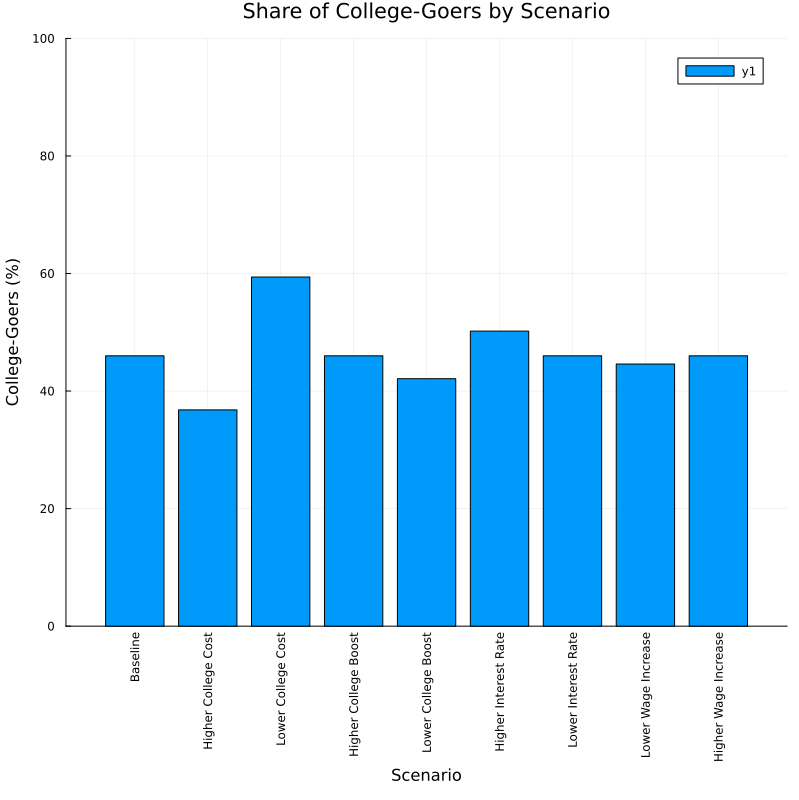

In [16]:


# 1) Define scenario labels and recorded results
scenarios = [
    "Baseline",
    "Higher College Cost",
    "Lower College Cost",
    "Higher College Boost",
    "Lower College Boost",
    "Higher Interest Rate",
    "Lower Interest Rate",
    "Lower Wage Increase",
    "Higher Wage Increase"
];

# Number choosing college and work, respectively
num_college = [2299, 1840, 2968, 2299, 2103, 2510, 2299, 2230, 2299];
num_work    = [2701, 3160, 2032, 2701, 2897, 2490, 2701, 2770, 2701];

# 2) Compute the fraction who choose college (percentage)
p_college = [num_college[i] / (num_college[i] + num_work[i]) for i in 1:length(scenarios)];
p_college_percent = p_college .* 100;

# 3) Create a DataFrame (round percentages for readability)
df = DataFrame(
    Scenario   = scenarios,
    College    = num_college,
    Work       = num_work,
    CollegePct = round.(p_college_percent, digits=1)
);

# 4) Display the table
#display(df);

# 5) Bar chart of the percentage who attend college, with vertical x-axis labels
bar(
    df.Scenario,
    df.CollegePct,
    xlabel    = "Scenario",
    ylabel    = "College-Goers (%)",
    title     = "Share of College-Goers by Scenario",
    ylims     = (0, 100),
    xrotation = 90,
    size      = (800,800)
)

### Average Simulation Paths by Group

This code extracts and visualizes the average time series for key variables (consumption, assets, hours, and capital) for agents grouped by their chosen path (college vs. work). The function `extract_simulation_by_path` computes the mean values at each period for both groups. After running the baseline simulation and capturing the `path_choice` vector, the code generates four plots (one for each variable) and combines them into a 2×2 grid. This visualization facilitates comparing how these state variables evolve over time for agents choosing college versus those choosing work.

Number choosing college: 2299
Number choosing work:    2701


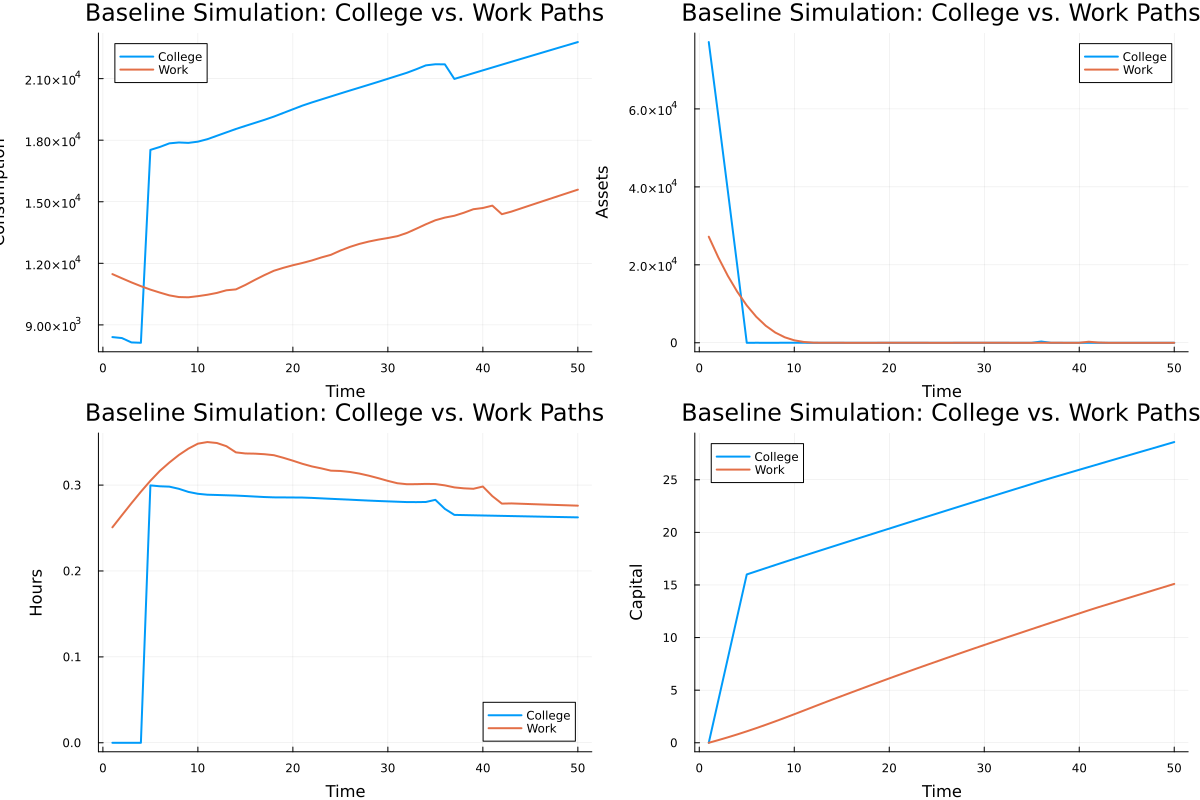

In [ ]:

# -----------------------------
# Extraction function to compute average time series by group
# -----------------------------
function extract_simulation_by_path(model, path_choice)
    T = model.T
    # Find indices of agents by their choice
    college_idx = findall(x -> x == :college, path_choice)
    work_idx    = findall(x -> x == :work, path_choice)
    
    # Compute the average for each time period over the agents in each group
    avg_c_college = [mean(model.sim_c[college_idx, t]) for t in 1:T]
    avg_c_work    = [mean(model.sim_c[work_idx, t]) for t in 1:T]
    
    avg_a_college = [mean(model.sim_a[college_idx, t]) for t in 1:T]
    avg_a_work    = [mean(model.sim_a[work_idx, t]) for t in 1:T]
    
    avg_h_college = [mean(model.sim_h[college_idx, t]) for t in 1:T]
    avg_h_work    = [mean(model.sim_h[work_idx, t]) for t in 1:T]
    
    avg_k_college = [mean(model.sim_k[college_idx, t]) for t in 1:T]
    avg_k_work    = [mean(model.sim_k[work_idx, t]) for t in 1:T]
    
    return (c = (college = avg_c_college, work = avg_c_work),
            a = (college = avg_a_college, work = avg_a_work),
            h = (college = avg_h_college, work = avg_h_work),
            k = (college = avg_k_college, work = avg_k_work))
end

# -----------------------------
# Now run the baseline simulation and then extract and plot the paths
# -----------------------------

# Run the baseline simulation and capture both the updated model and the path_choice vector
model_baseline, path_choice = simulate_model!(model_baseline);

# Extract average paths by group
sim_results = extract_simulation_by_path(model_baseline, path_choice);
t = 1:model_baseline.T  # time vector

# Plot 1: Consumption
p1 = plot(t, sim_results.c.college, label="College", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, sim_results.c.work, label="Work", lw=2)

# Plot 2: Assets
p2 = plot(t, sim_results.a.college, label="College", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, sim_results.a.work, label="Work", lw=2)

# Plot 3: Hours
p3 = plot(t, sim_results.h.college, label="College", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, sim_results.h.work, label="Work", lw=2)

# Plot 4: Capital
p4 = plot(t, sim_results.k.college, label="College", lw=2, xlabel="Time", ylabel="Capital")
plot!(t, sim_results.k.work, label="Work", lw=2)

# Combine the four plots into a 2x2 layout with an overall title
plot(p1, p2, p3, p4,
     layout = (2, 2),
     size = (1200, 800),
     title = "Baseline Simulation: College vs. Work Paths",
     titlefont = 16)